# Introduction: Automated GBM Hyperparameter Optimization

中文教程：https://www.jiqizhixin.com/articles/2018-08-08-2 

lgb递进调参：http://www.imooc.com/article/43784 xgboost调参：https://blog.csdn.net/u010665216/article/details/78532619?utm_source=blogxgwz4

lgb参考2：https://www.cnblogs.com/wanglei5205/p/8722237.html

In this notebook we will walk through automated hyperparameter tuning using Bayesian Optimization. Specifically, we will optimize the hyperparameters of a Gradient Boosting Machine using the Hyperopt library (with the Tree Parzen Estimator algorithm).  We will compare the results of random search (implemented manually) for hyperparameter tuning with the Bayesian model-based optimization method to try and understand how the Bayesian method works and what benefits it has over uninformed search methods. 

## Hyperopt

Hyperopt is one of several automated hyperparameter tuning libraries using Bayesian optimization. These libraries differ in the algorithm used to both construct the surrogate (probability model) of the objective function and choose the next hyperparameters to evaluate in the objective function. Hyperopt uses the Tree Parzen Estimator (TPE). Other Python libraries include Spearmint, which uses a Gaussian process for the surrogate, and SMAC, which uses a random forest regression. 

Hyperopt has a simple syntax for structuring an optimization problem which extends beyond hyperparameter tuning to any problem that involves minimizing a function. Moreover, the structure of a Bayesian Optimization problem is similar across the libraries, with the major differences coming in the syntax (and in the algorithms behind the scenes that we do not have to deal with). 

In [21]:
import pandas as pd
import numpy as np

# Modeling
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Evaluation of the model
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

MAX_EVALS = 200
N_FOLDS = 5

In [22]:
cd ../src

/home/wanshun/my_code/mobile/src


## Data

For this notebook we will work with only the `application` data. The methods developed here can work on any dataset but the run-times can be long! We will also separate the training set into training and testing to evaluate the performance of hyperparameter tuning.

In [23]:
# Read in data and separate into training and testing sets
path = '../data/'
train = pd.read_csv(path + 'datas_8classes.csv')
test = pd.read_csv(path + 'test_datas_8classes.csv')

classes = sorted(list(set(train['current_service'])))
label2current_service = dict(zip(range(0,len(classes)), classes))
current_service2label = dict(zip(classes,range(0,len(classes))))

train['current_service'] = train['current_service'].map(current_service2label)


y = train.pop('current_service')
train_id = train.pop('user_id')

X = train
train_col_tmp = ['former_complaint_fee','former_complaint_num','complaint_level']

print('pop column is ',train_col_tmp)
for itm in  train_col_tmp:
    train.pop(itm)
train_col = train.columns
features_num = len(train_col)
X_test = test[train_col]
test_id = test['user_id']


# for i in train_col:
    # X[i] = X[i].replace("\\N",-1)
    # X_test[i] = X_test[i].replace("\\N",-1)

train_features,y,test_features = X,y,X_test

print('Train shape: ', train_features.shape)
print('Test shape: ', test_features.shape)

train_features.head()

pop column is  ['former_complaint_fee', 'former_complaint_num', 'complaint_level']
Train shape:  (396635, 22)
Test shape:  (67163, 22)


,month_traffic,1_total_fee,2_total_fee,3_total_fee,4_total_fee,age,contract_time,local_caller_time,local_trafffic_month,online_time,...,service1_caller_time,service2_caller_time,last_month_traffic,service_type,is_mix_service,many_over_bill,contract_type,is_promise_low_consume,net_service,gender
0,1276.235687,137.35,136.00,156.00,195.95,37,12,472.383333,1276.275303,10,...,5.583333,638.933333,746.466083,4,1,0,6,0,4,1
1,443.197619,96.00,96.00,125.10,96.09,48,12,149.783333,435.072411,134,...,0.000000,171.516667,1024.000000,4,0,0,3,0,4,1
2,1296.080153,106.00,106.00,106.00,106.00,20,0,18.350000,1296.081185,17,...,0.000000,20.766667,735.982041,4,0,0,0,0,4,2
3,416.605755,136.10,157.45,120.00,120.00,44,24,0.000000,0.000000,51,...,0.000000,60.800000,0.000000,4,0,0,1,1,4,1
4,891.790241,446.92,544.54,329.33,512.90,28,0,2.700000,892.061959,66,...,54.066667,12.666667,7680.000000,4,0,1,0,0,4,0


In [24]:
# Create a lgb dataset
le_train_set = lgb.Dataset(train_features, label=y)

All we need to do is fit the model on the training data and make predictions on the testing data. For the predictions, because we are measuring ROC AUC and not accuracy, we have the model predict probabilities and not hard binary values.

Now, we can move on to Bayesian methods and see if they are able to achieve better results.

# Bayesian Hyperparameter Optimization using Hyperopt

For Bayesian optimization in Hyperopt, we need the following four parts:

1. Objective function
2. Domain space
3. Hyperparameter optimization algorithm
4. History of results

We already used all of these in random search, but for Hyperopt we will have to make a few changes.

## Objective Function 

This objective function will still take in the hyperparameters but it will return not a list but a dictionary. The only requirement for an objective function in Hyperopt is that it has a key in the return dictionary called `"loss"` to minimize and a key called `"status"` indicating if the evaluation was successful. 

If we want to keep track of the number of iterations, we can declare a global variables called `ITERATION` that is incremented every time the function is called. In addition to returning comprehensive results, every time the function is evaluated, we will write the results to a new line of a csv file. This can be useful for extremely long evaluations if we want to check on the progress (this might not be the most elegant solution, but it's better than printing to the console because our results will be saved!) 

The most important part of this function is that now we need to return a __value to minimize__ and not the raw ROC AUC. We are trying to find the best value of the objective function, and even though a higher ROC AUC is better, Hyperopt works to minimize a function. Therefore, a simple solution is to return 1 - ROC (we did this for random search as well for practice).

In [25]:
import csv
from hyperopt import STATUS_OK
from timeit import default_timer as timer

from sklearn.metrics import f1_score

def f1_score_vali(preds, data_vali):
    labels = data_vali.get_label()
    preds = np.argmax(preds.reshape(len(classes), -1), axis=0)
    score_vali = f1_score(y_true=labels, y_pred=preds, average=None)
    print(score_vali)
    score_vali = np.mean(score_vali)
    score_vali = score_vali * score_vali
    return 'f1_score', score_vali, True

def objective(params, n_folds = N_FOLDS):
    """Objective function for Gradient Boosting Machine Hyperparameter Optimization"""
    
    # Keep track of evals
    global ITERATION
    
    ITERATION += 1
    
    encoding_type = params['encoding']
    
    # Handle the encoding
    if encoding_type == 'one_hot':
        train_set = oh_train_set
    elif encoding_type == 'label':
        train_set = le_train_set
    
    del params['encoding']
    
    # Retrieve the subsample
    subsample = params['boosting_type'].get('subsample', 1.0)
    
    # Extract the boosting type and subsample to top level keys
    params['boosting_type'] = params['boosting_type']['boosting_type']
    params['subsample'] = subsample
    
    params['objective'] = "multiclass"
    params['metric'] = "multi_logloss"
    params['num_class'] = len(classes)
    params['is_unbalance'] = True
    params['verbosity'] = -1
    params["n_jobs"] = 4
    params['device'] = 'gpu'
    # "gpu_platform_id":-1,
    # "gpu_device_id":-1
    # 'gpu_use_dp':False
    
    # Make sure parameters that need to be integers are integers
    for parameter_name in ['num_leaves', 'subsample_for_bin', 'min_child_samples']:
        params[parameter_name] = int(params[parameter_name])
    
    start = timer()
    
    # Perform n_folds cross validation
    cv_results = lgb.cv(params, train_set, num_boost_round = 1000, nfold = n_folds, 
                        early_stopping_rounds = 100, feval=f1_score_vali, seed = 24)
    
    run_time = timer() - start
    
    # Extract the best score
    best_score = np.max(cv_results['f1_score-mean'])
    
    # Loss must be minimized
    loss = 1 - best_score
    
    # Boosting rounds that returned the highest cv score
    n_estimators = int(np.argmax(cv_results['f1_score-mean']) + 1)
    
    params['encoding'] = encoding_type
    
    if ITERATION % 100 == 0:
        # Display the information
        display('Iteration {}: {} Fold CV f1_score {:.5f}'.format(ITERATION, N_FOLDS, best_score))

    # Write to the csv file ('a' means append)
    of_connection = open(out_file, 'a')
    writer = csv.writer(of_connection)
    writer.writerow([loss, params, ITERATION, n_estimators, run_time, best_score])
    of_connection.close()
    
    # Dictionary with information for evaluation
    return {'loss': loss, 'params': params, 'iteration': ITERATION,
            'estimators': n_estimators, 
            'train_time': run_time, 'status': STATUS_OK}

Although Hyperopt only needs the `loss`, it's a good idea to track other metrics so we can inspect the results. Later we can compare the sequence of searches to that from random search which will help us understand how the method works. 

## Domain Space

Specifying the domain (called the `space` in Hyperopt) is a little trickier than in grid search. In Hyperopt, and other Bayesian optimization frameworks, the domian is not a discrete grid but instead has probability distributions for each hyperparameter. For each hyperparameter, we will use the same limits as with the grid, but instead of being defined at each point, the domain represents probabilities for each hyperparameter. This will probably become clearer in the code and the images! 

In [26]:
from hyperopt import hp
from hyperopt.pyll.stochastic import sample

First we will go through an example of the learning rate. Again, we are using a log-uniform space for the learning rate defined from 0.005 to 0.2 (same as with the grid.) This time, when we graph the domain, it's more accurate to see a kernel density estimate plot than a histogram (although both show distributions). 

In [27]:
# Create the learning rate
learning_rate = {'learning_rate': hp.loguniform('learning_rate', np.log(0.005), np.log(0.2))}

We can visualize the learning rate by sampling from the space using a Hyperopt utility. Here we plot 10000 samples.

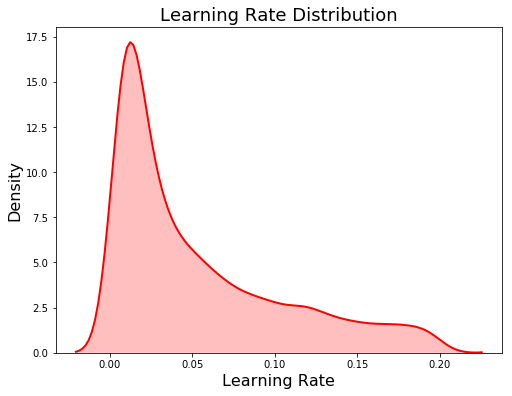

In [28]:
learning_rate_dist = []

# Draw 10000 samples from the learning rate domain
for _ in range(10000):
    learning_rate_dist.append(sample(learning_rate)['learning_rate'])
    
plt.figure(figsize = (8, 6))
sns.kdeplot(learning_rate_dist, color = 'red', linewidth = 2, shade = True);
plt.title('Learning Rate Distribution', size = 18); plt.xlabel('Learning Rate', size = 16); plt.ylabel('Density', size = 16);

The number of leaves is again a uniform distribution. Here we used `quniform` which means a discrete uniform (as opposed to continuous).

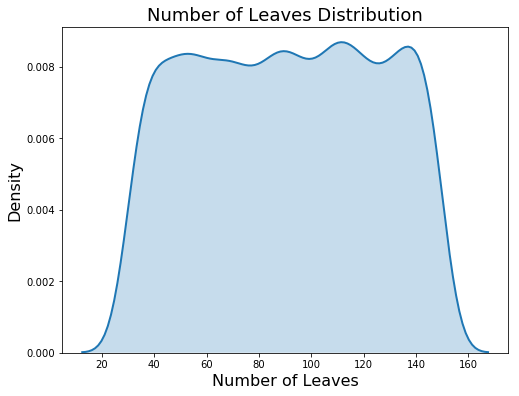

In [29]:
# Discrete uniform distribution
num_leaves = {'num_leaves': hp.quniform('num_leaves', 30, 150, 1)}
num_leaves_dist = []

# Sample 10000 times from the number of leaves distribution
for _ in range(10000):
    num_leaves_dist.append(sample(num_leaves)['num_leaves'])
    
# kdeplot
plt.figure(figsize = (8, 6))
sns.kdeplot(num_leaves_dist, linewidth = 2, shade = True);
plt.title('Number of Leaves Distribution', size = 18); plt.xlabel('Number of Leaves', size = 16); plt.ylabel('Density', size = 16);

### Conditional Domain

In Hyperopt, we can use nested conditional statements to indicate hyperparameters that depend on other hyperparameters. For example, we know that `goss` boosting type cannot use subsample, so when we set up the `boosting_type` categorical variable, we have to se the `subsample` to 1.0 while for the other boosting types it's a float between 0.5 and 1.0 Let's see this with an example:

In [30]:
# boosting type domain 
boosting_type = {'boosting_type': hp.choice('boosting_type', 
                                            [{'boosting_type': 'gbdt', 'subsample': hp.uniform('subsample', 0.5, 1)}, 
                                             {'boosting_type': 'dart', 'subsample': hp.uniform('subsample', 0.5, 1)},
                                             {'boosting_type': 'goss', 'subsample': 1.0}])}

# Draw a sample
params = sample(boosting_type)
params

{'boosting_type': {'boosting_type': 'gbdt', 'subsample': 0.975378771456646}}

We need to set both the `boosting_type` and `subsample` as top-level keys in the parameter dictionary. We can use the Python `dict.get` method with a default value of 1.0. This means that if the key is not present in the dictionary, the value returned will be the default (1.0).

In [31]:
# Retrieve the subsample if present otherwise set to 1.0
subsample = params['boosting_type'].get('subsample', 1.0)

# Extract the boosting type
params['boosting_type'] = params['boosting_type']['boosting_type']
params['subsample'] = subsample

params

{'boosting_type': 'gbdt', 'subsample': 0.975378771456646}

This is because the gbm cannot use the nested dictionary so we need to set the `boosting_type` and `subsample` as top level keys. Nested conditionals allow us to use a different set of hyperparameters depending on other hyperparameters. For example, we can explore different models with completely different sets of hyperparameters by using nested conditionals. The only requirement is that the first nested statement must be based on a `choice` hyperparameter (the choice could be the type of model).

## Complete Bayesian Domain

Now we can define the entire domain. Each variable needs to have a label and a few parameters specifying the type and extent of the distribution. For the variables such as boosting type that are categorical, we use the `choice` variable. Other variables types include `quniform`, `loguniform`, and `uniform`. For the complete list, check out the [documentation](https://github.com/hyperopt/hyperopt/wiki/FMin) for Hyperopt.

In [32]:
# Define the search space
space = {
    'encoding': hp.choice('encoding', ['label']),
    'class_weight': hp.choice('class_weight', [None, 'balanced']),
    'boosting_type': hp.choice('boosting_type', 
                                            [{'boosting_type': 'gbdt', 'subsample': hp.uniform('gdbt_subsample', 0.5, 1)}]),
    'num_leaves': hp.quniform('num_leaves', 30, 150, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.1), np.log(0.2)),
    'subsample_for_bin': hp.quniform('subsample_for_bin', 20000, 300000, 20000),
    'min_child_samples': hp.quniform('min_child_samples', 20, 500, 5),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.6, 1.0),
}

### Example of Sampling from the Domain 

Let's sample from the domain (using the conditional logic) to see the result of each draw. Every time we run this code, the results will change. (Again notice that we need to assign the top level keys to the keywords understood by the GBM).

In [33]:
# Sample from the full space
x = sample(space)

# Conditional logic to assign top-level keys
subsample = x['boosting_type'].get('subsample', 1.0)
x['boosting_type'] = x['boosting_type']['boosting_type']
x['subsample'] = subsample

x

{'boosting_type': 'gbdt',
 'class_weight': 'balanced',
 'colsample_bytree': 0.799586515091031,
 'encoding': 'label',
 'learning_rate': 0.10512523191893401,
 'min_child_samples': 340.0,
 'num_leaves': 60.0,
 'reg_alpha': 0.11224318940698397,
 'reg_lambda': 0.8925990796997245,
 'subsample': 0.6282036995243927,
 'subsample_for_bin': 20000.0}

In [34]:
x = sample(space)
subsample = x['boosting_type'].get('subsample', 1.0)
x['boosting_type'] = x['boosting_type']['boosting_type']
x['subsample'] = subsample
x

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 0.6192440853524482,
 'encoding': 'label',
 'learning_rate': 0.11899529775420577,
 'min_child_samples': 410.0,
 'num_leaves': 40.0,
 'reg_alpha': 0.6066987885761421,
 'reg_lambda': 0.22202461282423602,
 'subsample': 0.5998382024267694,
 'subsample_for_bin': 300000.0}

## Optimization Algorithm

Although this is the most technical part of Bayesian optimization, defining the algorithm to use in Hyperopt is simple. We will use the Tree Parzen Estimator (read about it [in this paper](https://papers.nips.cc/paper/4443-algorithms-for-hyper-parameter-optimization.pdf)) which is one method for constructing the surrogate function and choosing the next hyperparameters to evaluate. 

In [35]:
from hyperopt import tpe

tpe_algorithm = tpe.suggest

## Results History

The final part is the result history. Here, we are using two methods to make sure we capture all the results:

1. A `Trials` object that stores the dictionary returned from the objective function
2. Writing to a csv file every iteration

The csv file option also lets us monitor the results of an on-going experiment. (Although do not use Excel to open the file while training is on-going. Instead check the results using `tail results/gbm_trials.csv` from bash or another command line.

In [36]:
from hyperopt import Trials

trials = Trials()

The `Trials` object will hold everything returned from the objective function in the `.results` attribute. It also holds other information from the search, but we return everything we need from the objective. 

In [37]:
# File to save first results
out_file = '../result/gbm_f1_results_kaggle.csv'
of_connection = open(out_file, 'w')
writer = csv.writer(of_connection)

# Write the headers to the file
writer.writerow(['loss', 'params', 'iteration', 'estimators', 'time', 'ROC AUC'])
of_connection.close()

Every time the objective function is called, it will write one line to this file. Running the cell above does clear the file though.

## Bayesian Optimization

We have everything in place needed to run the optimization. First we declare the global variable that will be used to keep track of the number of iterations. Then, we call `fmin` passing in everything we defined above and the maximum number of iterations to run.

In [ ]:
from hyperopt import fmin

In [ ]:
%%capture

# Global variable
global  ITERATION

ITERATION = 0

# Run optimization
best = fmin(fn = objective, space = space, algo = tpe.suggest, 
            max_evals = MAX_EVALS, trials = trials, verbose = 1)

The `.results` attribute of the `Trials` object has all information from the objective function. If we sort this by the lowest loss, we can see the hyperparameters that performed the best in terms of validation loss. 

In [ ]:
# Sort the trials with lowest loss (highest AUC) first
trials_results = sorted(trials.results, key = lambda x: x['loss'])
trials_results[:2]

We can also access the results from the csv file (which might be easier since it's already a dataframe).

In [ ]:
results = pd.read_csv('../result/gbm_f1_results_kaggle.csv')

# Sort with best scores on top and reset index for slicing
results.sort_values('loss', ascending = True, inplace = True)
results.reset_index(inplace = True, drop = True)
results.head()

For some reason, when we save to a file and then read back in, the dictionary of hyperparameters is represented as a string. To convert from a string back to a dictionary we can use the `ast` library and the `literal_eval` function.

In [ ]:
import ast

# Convert from a string to a dictionary
ast.literal_eval(results.loc[0, 'params'])

## Evaluate Best Results

Now for the moment of truth: did the optimization pay off? For this problem with a relatively small dataset, the benefits of hyperparameter optimization compared to random search are probably minor (if there are any). Random search might turn up a better result in fewer iterations simply becuase of randomness! 

In [ ]:
# Extract the ideal number of estimators and hyperparameters
best_bayes_estimators = int(results.loc[0, 'estimators'])
best_bayes_params = ast.literal_eval(results.loc[0, 'params']).copy()

# Re-create the best model and train on the training data
best_bayes_model = lgb.LGBMClassifier(n_estimators=best_bayes_estimators, 
                                      n_jobs = -1, 
                                      objective = 'binary', 
                                      random_state = 50, 
                                      **best_bayes_params)
best_bayes_model.fit(one_hot_features, labels)

In [ ]:
# Evaluate on the testing data 
preds = best_bayes_model.predict_proba(one_hot_features_test)[:, 1]
print('The best model from Bayes optimization scores {:.5f} AUC ROC on the test set.'.format(roc_auc_score(test_labels, preds)))
print('This was achieved after {} search iterations'.format(results.loc[0, 'iteration']))

If we want to save the results, we can use the json file format. Saving the trials results will allow us to continue the hyperparameter search where we left off.

In [ ]:
import json

# Save the trial results
with open('trials_kaggle.json', 'w') as f:
    f.write(json.dumps(trials_results))

## Visualizing Hyperparameters

One interesting thing we can do with the results is to see the different hyperparameters tried by both random search and the Tree Parzen Estimator. Since random search is choosing without regards to the previous results, we would expect that the distribution of samples should be close to the domain space we defined (it won't be exact since we are using a fairly small number of iterations). On the other hand, the Bayes Optimization, if given enough time, should concetrate on the "more promising" hyperparameters. 

In addition to a more concentrated search, we expect that the average validation loss of the Bayesian Optimization should be lower than that on the random search because it chooses values likely (according to the probability model) to yield lower losses on the objective function. The validation loss should also decrease over time with the Bayesian method. 

First we will need to extract the hyperparameters from both search methods. We will store these in separate dataframes.

In [ ]:
# Create a new dataframe for storing parameters
random_params = pd.DataFrame(columns = list(random_results.loc[0, 'params'].keys()),
                            index = list(range(len(random_results))))

# Add the results with each parameter a different column
for i, params in enumerate(random_results['params']):
    random_params.loc[i, :] = list(params.values())
    
random_params['loss'] = random_results['loss']
random_params['iteration'] = random_results['iteration']
random_params.head()

In [ ]:
# Create a new dataframe for storing parameters
bayes_params = pd.DataFrame(columns = list(ast.literal_eval(results.loc[0, 'params']).keys()),
                            index = list(range(len(results))))

# Add the results with each parameter a different column
for i, params in enumerate(results['params']):
    bayes_params.loc[i, :] = list(ast.literal_eval(params).values())
    
bayes_params['loss'] = results['loss']
bayes_params['iteration'] = results['iteration']

bayes_params.head()

#### Learning Rates

The first plot shows the sampling distribution, random search, and Bayesian optimization learning rate distributions. 

In [ ]:
plt.figure(figsize = (20, 8))
plt.rcParams['font.size'] = 18

# Density plots of the learning rate distributions 
sns.kdeplot(learning_rate_dist, label = 'Sampling Distribution', linewidth = 4)
sns.kdeplot(random_params['learning_rate'], label = 'Random Search', linewidth = 4)
sns.kdeplot(bayes_params['learning_rate'], label = 'Bayes Optimization', linewidth = 4)
plt.vlines([best_random_params['learning_rate'], best_bayes_params['learning_rate']],
           ymin = 0.0, ymax = 50.0, linestyles = '--', linewidth = 4, colors = ['orange', 'green'])
plt.legend()
plt.xlabel('Learning Rate'); plt.ylabel('Density'); plt.title('Learning Rate Distribution');

#### Boosting Type 

Random search should use the boosting types with the same frequency. However, Bayesian Optimization might have decided (modeled) that one boosting type is better than another for this problem.

In [ ]:
fig, axs = plt.subplots(1, 2, sharey = True, sharex = True)

# Bar plots of boosting type
random_params['boosting_type'].value_counts().plot.bar(ax = axs[0], figsize = (14, 6), color = 'orange', title = 'Random Search Boosting Type')
bayes_params['boosting_type'].value_counts().plot.bar(ax = axs[1], figsize = (14, 6), color = 'green', title = 'Bayes Optimization Boosting Type');

In [ ]:
print('Random Search boosting type percentages')
100 * random_params['boosting_type'].value_counts() / len(random_params)

In [ ]:
print('Bayes Optimization boosting type percentages')
100 * bayes_params['boosting_type'].value_counts() / len(bayes_params)

### Plots of All Numeric Hyperparameters

In [ ]:
# Iterate through each hyperparameter
for i, hyper in enumerate(random_params.columns):
    if hyper not in ['class_weight', 'boosting_type', 'iteration', 'subsample', 'metric', 'verbose', 'loss', 'learning_rate', 'encoding']:
        plt.figure(figsize = (14, 6))
        # Plot the random search distribution and the bayes search distribution
        if hyper != 'loss':
            sns.kdeplot([sample(space[hyper]) for _ in range(1000)], label = 'Sampling Distribution', linewidth = 4)
        sns.kdeplot(random_params[hyper], label = 'Random Search', linewidth = 4)
        sns.kdeplot(bayes_params[hyper], label = 'Bayes Optimization', linewidth = 4)
        plt.vlines([best_random_params[hyper], best_bayes_params[hyper]],
                     ymin = 0.0, ymax = 10.0, linestyles = '--', linewidth = 4, colors = ['orange', 'green'])
        plt.legend(loc = 1)
        plt.title('{} Distribution'.format(hyper))
        plt.xlabel('{}'.format(hyper)); plt.ylabel('Density');
        plt.show();

## Evolution of Hyperparameters

We can also plot the hyperparameters over time (against the number of iterations) to see how they change for the Bayes Optimization. First we will map the `boosting_type` to an integer for plotting.

In [ ]:
# Map boosting type to integer (essentially label encoding)
bayes_params['boosting_int'] = bayes_params['boosting_type'].replace({'gbdt': 1, 'goss': 2, 'dart': 3})

# Plot the boosting type over the search
plt.plot(bayes_params['iteration'], bayes_params['boosting_int'], 'ro')
plt.yticks([1, 2, 3], ['gdbt', 'goss', 'dart']);
plt.xlabel('Iteration'); plt.title('Boosting Type over Search');

In [ ]:
fig, axs = plt.subplots(1, 4, figsize = (24, 6))
i = 0

# Plot of four hyperparameters
for i, hyper in enumerate(['colsample_bytree', 'learning_rate', 'min_child_samples', 'num_leaves']):
    
        # Scatterplot
        sns.regplot('iteration', hyper, data = bayes_params, ax = axs[i])
        axs[i].scatter(best_bayes_params['iteration'], best_bayes_params[hyper], marker = '*', s = 200, c = 'k')
        axs[i].set(xlabel = 'Iteration', ylabel = '{}'.format(hyper), title = '{} over Search'.format(hyper));

plt.tight_layout()

In [ ]:
best_bayes_params

In [ ]:
fig, axs = plt.subplots(1, 3, figsize = (18, 6))
i = 0

# Scatterplot of next three hyperparameters
for i, hyper in enumerate(['reg_alpha', 'reg_lambda', 'subsample_for_bin']):
        sns.regplot('iteration', hyper, data = bayes_params, ax = axs[i])
        axs[i].scatter(best_bayes_params['iteration'], best_bayes_params[hyper], marker = '*', s = 200, c = 'k')
        axs[i].set(xlabel = 'Iteration', ylabel = '{}'.format(hyper), title = '{} over Search'.format(hyper));

plt.tight_layout()

#### Validation Losses

Finally, we can look at the losses recorded by both random search and Bayes Optimization. We would expect the average loss recorded by Bayes Optimization to be lower because this method should spend more time in promising regions of the search space.

In [ ]:
# Dataframe of just scores
scores = pd.DataFrame({'ROC AUC': 1 - random_params['loss'], 'iteration': random_params['iteration'], 'search': 'random'})
scores = scores.append(pd.DataFrame({'ROC AUC': 1 - bayes_params['loss'], 'iteration': bayes_params['iteration'], 'search': 'Bayes'}))

scores['ROC AUC'] = scores['ROC AUC'].astype(np.float32)
scores['iteration'] = scores['iteration'].astype(np.int32)

scores.head()

We can make histograms of the scores (not taking in account the iteration) on the same x-axis scale to see if there is a difference in scores.

In [ ]:
plt.figure(figsize = (18, 6))

# Random search scores
plt.subplot(1, 2, 1)
plt.hist(1 - random_results['loss'].astype(np.float64), label = 'Random Search', edgecolor = 'k');
plt.xlabel("Validation ROC AUC"); plt.ylabel("Count"); plt.title("Random Search Validation Scores")
plt.xlim(0.75, 0.78)

# Bayes optimization scores
plt.subplot(1, 2, 2)
plt.hist(1 - bayes_params['loss'], label = 'Bayes Optimization', edgecolor = 'k');
plt.xlabel("Validation ROC AUC"); plt.ylabel("Count"); plt.title("Bayes Optimization Validation Scores");
plt.xlim(0.75, 0.78);

It does appear that the validation ROC AUC for the Bayesian optimization is higher than that for Random Search. However, as we have seen, this does not necessarily translate to a better testing score! 

Bayesian optimization should get better over time. Let's plot the scores against the iteration to see if there was improvement.

In [ ]:
# Plot of scores over the course of searching
sns.lmplot('iteration', 'ROC AUC', hue = 'search', data = scores, size = 8);
plt.scatter(best_bayes_params['iteration'], 1 - best_bayes_params['loss'], marker = '*', s = 400, c = 'orange', edgecolor = 'k')
plt.scatter(best_random_params['iteration'], 1 - best_random_params['loss'], marker = '*', s = 400, c = 'blue', edgecolor = 'k')
plt.xlabel('Iteration'); plt.ylabel('ROC AUC'); plt.title("Validation ROC AUC versus Iteration");

It's reassuring to see that the validation ROC AUC scores of Bayesian optimization increase over time. What this shows is that the model is exploring hyperparameters that are better according to the cross validation metric! It would be interesting to continue searching and see if there is a plateau in the validation scores (there would have to be eventually). Moreover, even if validation scores continue to increase, that does not mean a better model for the testing data! 

In [ ]:
# Save dataframes of parameters
bayes_params.to_csv('results/bayes_params_kaggle.csv', index = False)
random_params.to_csv('results/random_params_kaggle.csv', index = False)

## Continue Searching

We can keep running the Bayesian hyperparameter search for more iterations to try for better results. Hyperopt will continue searching where it left off if we [pass it a trials object that already has information on previous runs](https://github.com/hyperopt/hyperopt/issues/267). This raises a good point: always save your previous results, because you never know when they will be useful! 

Another interesting point to not is that Bayesian Optimization methods do not have any internal state which means all they need are the results: previous inputs to the objective function and the resulting loss. Based only on these results, these methods can construct a surrogate function and suggest the next set of hyperparameters to evaluate. The internals of the objective function have no effect on the Bayesian Optimization method hence the naming of this as a black box optimization method.

In [ ]:
# Continue training
ITERATION = MAX_EVALS + 1

# Set more evaluations
MAX_EVALS = 1000

In [ ]:
%%capture

# Use the same trials object to keep training
best = fmin(fn = objective, space = space, algo = tpe.suggest, 
            max_evals = MAX_EVALS, trials = bayes_trials, verbose = 1, 
            rstate = np.random.RandomState(50))

In [ ]:
# Sort the trials with lowest loss (highest AUC) first
bayes_trials_results = sorted(bayes_trials.results, key = lambda x: x['loss'])
bayes_trials_results[:2]

In [ ]:
results = pd.read_csv('results/gbm_trials_kaggle.csv')

# Sort values with best on top and reset index for slicing
results.sort_values('loss', ascending = True, inplace = True)
results.reset_index(inplace = True, drop = True)
results.head()

In [ ]:
# Extract the ideal number of estimators and hyperparameters
best_bayes_estimators = int(results.loc[0, 'estimators'])
best_bayes_params = ast.literal_eval(results.loc[0, 'params']).copy()

# Re-create the best model and train on the training data
best_bayes_model = lgb.LGBMClassifier(n_estimators=best_bayes_estimators, n_jobs = -1, 
                                       objective = 'binary', random_state = 50, **best_bayes_params)
best_bayes_model.fit(features, labels)

In [ ]:
# Evaluate on the testing data 
preds = best_bayes_model.predict_proba(test_features)[:, 1]
print('The best model from Bayes optimization scores {:.5f} AUC ROC on the test set.'.format(roc_auc_score(test_labels, preds)))
print('This was achieved after {} search iterations'.format(results.loc[0, 'iteration']))

The continuation of the search did slightly improve the validation score (again depending on training run). Instead of training more, we might want to restart the search so the algorithm can spend more time exploring the domain space. As searching continues, the algorithm shifts from exploring (trying new values) to exploiting (trying those values that worked best in the past). This is generally what we want unless the model gets stuck in a local minimum at which point we would want to restart the search in a different region of the hyperparameter space. Bayesian Optimization of hyperparameters is still prone to overfitting, even when using cross-validation because it can get settle into a local minimum of the objective function. It is very difficult to tell when this occurs for a high-dimensional problem!

# Conclusions

In this notebook, we saw how to implement automated hyperparameter tuning with Bayesian Optimization methods. We used the open-source Python library Hyperopt with the Tree Parzen Estimator to optimize the hyperparameters of a gradient boosting machine. 

Bayesian model-based optimization can be more efficient than random search, finding a better set of model hyperparameters in fewer search iterations (although not in every case). However, just because the model hyperparameters are better on the validation set does not mean they are better for the testing set! For this training run, Bayesian Optimization found a better set of hyperparamters according to the validation and the test data although the testing score was much lower than the validation ROC AUC. This is a useful lesson that even when using cross-validation, overfitting is still one of the top problems in machine learning. 

Bayesian optimization  is a powerful technique that we can use to tune any machine learning model, so long as we can define an objective function that returns a value to minimize and a domain space over which to search. This can extend to any function that we want to minimize (not just hyperparameter tuning). Bayesian optimization can be a significant upgrade over uninformed methods such as random search and because of the ease of use in Python are now a good option to use for hyperparameter tuning. As with most subjects in machine learning, there is no single best answer for hyperparameter tuning, but Bayesian optimization methods should be a tool that helps data scientists with the tedious but necessary task of model tuning! 